In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MultiLabelBinarizer
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### **Variables & Description**

|   variable_name  | type |                     desc                     |
|:----------------:|:----:|:--------------------------------------------:|
| `proj`           | df   | main DataFrame                               |
| `services`       | list | list of all subscription services            |
| `all_gen`        | list | list of all available genres                 |
| `countries_list` | list | list of all countries                        |
| `service_pipe`   | df   | proj joined with `Services` one hot encoding |
| `genre_pipe`     | df   | proj joined with `Genres` one hot encoding   |
|                  |      |                                              |

#### Initial Set-up and reading the data:

In [2]:
#initial set-up
proj = pd.read_csv('project.csv', names=['ShowName', 'Links', 'Imdb', 'Reelgood', 'Genres', 'MaturityRating', 'RunningDate', 'Seasons', 'ReturningDate', 'Service', 'Country'], header=0)

# for some fucking reason... pag ni iterate mo what looks like a god damn list... turns out.. it's not
# for i in proj.Country: #Same for Genres and Services
#     for j in i:
#         time.sleep(1)
#         print(j)

services = ['Netflix', 'Hulu', 'Prime Video', 'Disney+', 'HBO', 'HBO MAX', 
            'Peacock', 'Apple TV+', 'fuboTV', 'Showtime', 'Starz', 
            'CBS All Access','Epix', 'Crunchyroll', 'Funimation', 'AMC Premiere', 
            'Kanopy', 'Hoopla', 'The Criterion Channel', 'BritBox', 'DC Universe', 
            'Mubi', 'Cinemax', 'Fandor', 'AcornTV', 'Hallmark Movies Now', 'BET+', 
            'Youtube Premium','IndieFlix']

all_gen = ['Action & Adventure', 'Animation', 'Anime', 'Children', 'Comedy', 'Crime', 
           'Documentary', 'Drama', 'Family', 'Fantasy', 'Food', 'Game Show','Home & Garden',
           'Horror','LGBTQ', 'Mystery', 'Reality', 'Science-Fiction', 'Sport', 'Stand-up & Talk', 'Travel']

countries_list = ['America','Argentina','Australia','Austria','Belgium','Brazil','British Indian Ocean Territory','Bulgaria','Canada',
                  'Chile','China','Colombia','Columbia','Croatia','Czechia','Denmark',
                  'Egypt','Finland','France','Germany','Hong Kong','Hungary',
                  'Iceland','India','Iraq','Ireland','Israel','Italy','Japan',
                  'Luxembourg','Malaysia','Mexico','Netherlands','New Zealand',
                  'Norway','Philippines','Poland','Puerto Rico','Russia','South Africa',
                  'South Korea','Spain','Sweden','Switzerland','Taiwan','Thailand','Turkey','United Kingdom']

def New_Services(serve):
    new_list=[]
    for service in services:
        if service in serve:
            new_list.append(service)
    return new_list

def New_Genres(more_gen):
    Genre = []
    for gen in all_gen:
        if gen in more_gen:
            Genre.append(gen)
    return Genre

def New_Countries(cntry):
    new_country = []
    for i in countries_list:
        if i in cntry:
            new_country.append(i)
    return new_country

proj['Service'] = proj['Service'].astype(str).apply(New_Services)
proj['Genres'] = proj['Genres'].astype(str).apply(New_Genres)
proj['Country'] = proj['Country'].astype(str).apply(New_Countries)

#### Manipulating RunningDate
- separate `StartDate` and `EndDate`
- new column `RunYears`
    - `EndDate` - `StartDate`
    - if present 2020
    
|    StartDate     |    EndDate     |       RunYears       |
|:----------------:|:--------------:|:--------------------:|
| RunningDate[0]   | RunningDate[1] | EndDate - StartDate  |

In [3]:
#handling running dates
proj['StartDate'] = proj['RunningDate'].apply(lambda x: int(x.split(' - ')[0]))
proj['EndDate'] = proj['RunningDate'].apply(lambda x: 2020 if x.split(' - ')[1] == 'Present' else int(x.split(' - ')[1]))
proj['RunYears'] = proj['EndDate'] - proj['StartDate']

#### Manipulating Maturity Rating
- set type as category (Order)
    - Rated: All (TV-G)
    - Rated: 7+ (TV-PG)
    - Rated: 13
    - Rated: 14+ (TV-14)
    - Rated: 18+ (TV-MA)

In [4]:
cat_type = CategoricalDtype(categories=['Rated: All (TV-G)','Rated: 7+ (TV-PG)',
                                        'Rated: 13','Rated: 14+ (TV-14)','Rated: 18+ (TV-MA)'], ordered=True)
proj['MaturityRating'] = proj.MaturityRating.astype(cat_type)

In [5]:
proj['MaturityRating'].unique()

[Rated: 18+ (TV-MA), Rated: 14+ (TV-14), Rated: 7+ (TV-PG), NaN, Rated: All (TV-G)]
Categories (4, object): [Rated: All (TV-G) < Rated: 7+ (TV-PG) < Rated: 14+ (TV-14) < Rated: 18+ (TV-MA)]

### Manipulating Seasons
- Making Seasons Categorical (Ordered)
    - idea here is for easy manipulation like using [cut()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html#pandas.cut) to make bins
    - also categorical data is smaller and faster

In [6]:
proj['Seasons'].unique()

array(['5 Seasons', '8 Seasons', '4 Seasons', '3 Seasons', '2 Seasons',
       '1 Season', '10 Seasons', '9 Seasons', '15 Seasons', '31 Seasons',
       '6 Seasons', '7 Seasons', '23 Seasons', '12 Seasons', '11 Seasons',
       '14 Seasons', '16 Seasons', '24 Seasons', '27 Seasons',
       '19 Seasons', '18 Seasons', '17 Seasons', '21 Seasons',
       '28 Seasons', '13 Seasons', '29 Seasons', '25 Seasons',
       '45 Seasons', '40 Seasons', '20 Seasons', '51 Seasons',
       '35 Seasons', '62 Seasons', '44 Seasons', '54 Seasons',
       '32 Seasons', '22 Seasons', '26 Seasons', '36 Seasons',
       '34 Seasons', '52 Seasons', '41 Seasons', '37 Seasons',
       '42 Seasons', '33 Seasons', '38 Seasons', '39 Seasons',
       '43 Seasons', '48 Seasons', '57 Seasons'], dtype=object)

In [7]:
sea_type = CategoricalDtype(categories=['1 Season', '2 Seasons','3 Seasons','4 Seasons','5 Seasons',
                                        '6 Seasons','7 Seasons','8 Seasons','9 Seasons','10 Seasons',
                                        '11 Seasons','12 Seasons','13 Seasons','14 Seasons','15 Seasons',
                                        '16 Seasons','17 Seasons','18 Seasons','19 Seasons','20 Seasons',
                                        '21 Seasons','22 Seasons','23 Seasons','24 Seasons','25 Seasons',
                                        '26 Seasons','27 Seasons','28 Seasons','29 Seasons','31 Seasons',
                                        '32 Seasons', '33 Seasons','34 Seasons','35 Seasons','36 Seasons',
                                        '37 Seasons','38 Seasons','39 Seasons','40 Seasons','41 Seasons',
                                        '42 Seasons','43 Seasons','44 Seasons','45 Seasons','48 Seasons',
                                        '51 Seasons','52 Seasons','54 Seasons','57 Seasons','62 Seasons'], ordered=True)
proj['Seasons'] = proj.Seasons.astype(sea_type)     

### Possible Questions:

- Running dates:
    - inspect how many years did the show ran and it's ratings
    - how many shows are still running.
        - ratings
        - genres
    - how many shows has ended.
        - ratings
        - genres
- Genres:
    - how many shows per genre: %
    - highest rated per genre
- Maturity rating:
    - how many shows per rating %
    - highest rated per rating
- Services:
    - shows available per Service
    - top shows per service
- Seasons:
    - heatmap no of seasons per service
        - what services have a higher retention of shows
- Correlation:
    - ratings vs running time
    - ratings vs genres
    - ratings vs countries
    - ratings vs maturity ratings
    - does ratings affect the no of seasons

### Descriptive Stats

In [8]:
proj.head()

,ShowName,Links,Imdb,Reelgood,Genres,MaturityRating,RunningDate,Seasons,ReturningDate,Service,Country,StartDate,EndDate,RunYears
0,Breaking Bad,https://reelgood.com/show/breaking-bad-2008,9.5,100.0,"[Crime, Drama]",Rated: 18+ (TV-MA),2008 - 2013,5 Seasons,Series Ended,[Netflix],[America],2008,2013,5
1,Game of Thrones,https://reelgood.com/show/game-of-thrones-2011,9.3,99.0,"[Action & Adventure, Drama, Fantasy, Science-F...",Rated: 18+ (TV-MA),2011 - 2019,8 Seasons,Series Ended,"[HBO, HBO MAX]",[America],2011,2019,8
2,Rick and Morty,https://reelgood.com/show/rick-and-morty-2013,9.2,97.0,"[Action & Adventure, Animation, Comedy, Fantas...",Rated: 18+ (TV-MA),2013 - Present,4 Seasons,Returning: Date TBA,"[Hulu, HBO, HBO MAX, fuboTV, Hoopla]",[America],2013,2020,7
3,Stranger Things,https://reelgood.com/show/stranger-things-2016,8.8,96.0,"[Action & Adventure, Drama, Fantasy, Horror, M...",Rated: 14+ (TV-14),2016 - Present,3 Seasons,Returning: Date TBA,[Netflix],[America],2016,2020,4
4,Dark,https://reelgood.com/show/dark-2017,8.8,95.0,"[Crime, Drama, Fantasy, Mystery, Science-Fiction]",Rated: 14+ (TV-14),2017 - 2020,3 Seasons,Series Ended,[Netflix],[Germany],2017,2020,3


In [9]:
proj.columns 

Index(['ShowName', 'Links', 'Imdb', 'Reelgood', 'Genres', 'MaturityRating',
       'RunningDate', 'Seasons', 'ReturningDate', 'Service', 'Country',
       'StartDate', 'EndDate', 'RunYears'],
      dtype='object')

In [10]:
proj.shape

(9778, 14)

In [11]:
proj.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9778 entries, 0 to 9777
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ShowName        9778 non-null   object  
 1   Links           9778 non-null   object  
 2   Imdb            8282 non-null   float64 
 3   Reelgood        9294 non-null   float64 
 4   Genres          9778 non-null   object  
 5   MaturityRating  6012 non-null   category
 6   RunningDate     9778 non-null   object  
 7   Seasons         9778 non-null   category
 8   ReturningDate   9778 non-null   object  
 9   Service         9778 non-null   object  
 10  Country         9778 non-null   object  
 11  StartDate       9778 non-null   int64   
 12  EndDate         9778 non-null   int64   
 13  RunYears        9778 non-null   int64   
dtypes: category(2), float64(2), int64(3), object(7)
memory usage: 5.4 MB


In [12]:
proj.dtypes

ShowName            object
Links               object
Imdb               float64
Reelgood           float64
Genres              object
MaturityRating    category
RunningDate         object
Seasons           category
ReturningDate       object
Service             object
Country             object
StartDate            int64
EndDate              int64
RunYears             int64
dtype: object

In [13]:
proj.describe()

,Imdb,Reelgood,StartDate,EndDate,RunYears
count,8282.000000,9294.000000,9778.000000,9778.000000,9778.000000
mean,7.042272,49.406606,2010.544794,2014.788403,4.243608
std,1.116074,17.560583,11.518230,10.053876,6.770087
min,1.000000,10.000000,1901.000000,1939.000000,-40.000000
25%,6.500000,39.000000,2009.000000,2014.000000,1.000000
50%,7.200000,50.000000,2014.000000,2020.000000,3.000000
75%,7.800000,61.000000,2017.000000,2020.000000,5.000000
max,9.600000,100.000000,2020.000000,2020.000000,119.000000


In [14]:
# Daming NaN Countries
proj.isna().sum()

ShowName             0
Links                0
Imdb              1496
Reelgood           484
Genres               0
MaturityRating    3766
RunningDate          0
Seasons              0
ReturningDate        0
Service              0
Country              0
StartDate            0
EndDate              0
RunYears             0
dtype: int64

#### 1. What are the top 10 shows on IMDB that are available on each streaming service? And what are their ratings

In [15]:
# One Hot Encoding
def one_hot_encoding(dataframe, col):
    '''just run once you bitch'''
    mlb = MultiLabelBinarizer()
    new = dataframe.join(pd.DataFrame(mlb.fit_transform(dataframe.pop(col)),
                                      columns=mlb.classes_,index=dataframe.index))
    return new
# mlb.classes_

# Get encoded then sort while filtering columns
def get_encoded_sort_desc(dataframe, col_one_hot_encoded, sort_by_col, filter_cols):
    sorteddf = dataframe[dataframe[col_one_hot_encoded] == 1].sort_values(by=sort_by_col,ascending=False).filter(items=filter_cols)
    return sorteddf.reset_index(drop=True)

In [16]:
# pipelines note: run once cuz you poppin
service_pipe = proj.pipe(one_hot_encoding,col='Service')
genres_pipe = proj.pipe(one_hot_encoding,col='Genres')
country_pipe = proj.pipe(one_hot_encoding,col='Country')

In [17]:
# Run this for codes
# IMDB - sorry katamaran lolz
for element in services:
    print(f"{element} on IMDB\nservice_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='{element}',sort_by_col='Imdb',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('{element}')\n") 

Netflix on IMDB
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Netflix',sort_by_col='Imdb',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Netflix')

Hulu on IMDB
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Hulu',sort_by_col='Imdb',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Hulu')

Prime Video on IMDB
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Prime Video',sort_by_col='Imdb',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Prime Video')

Disney+ on IMDB
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Disney+',sort_by_col='Imdb',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Disney+')

HBO on IMDB
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='HBO',sort_by_col='Imdb',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('HBO')

HBO MAX on IMDB
service_pipe.pipe(get_encoded_sort_desc,col_one_

In [18]:
# Netflix
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Netflix',sort_by_col='Imdb',
                  filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Netflix')

,ShowName,Imdb,Reelgood
0,Breaking Bad,9.500000,100.000000
1,Our Planet,9.300000,83.000000
2,The Last Dance,9.200000,90.000000
3,Ramayan,9.200000,68.000000
4,Yeh Meri Family,9.200000,72.000000
5,Baseball,9.200000,65.000000
6,Avatar: The Last Airbender,9.200000,94.000000
7,Fullmetal Alchemist: Brotherhood,9.100000,89.000000
8,Holmes Buy It Right,9.100000,40.000000
9,The Vietnam War,9.100000,81.000000


In [19]:
# Hulu
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Hulu',sort_by_col='Imdb',
                  filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Hulu')

,ShowName,Imdb,Reelgood
0,The Last Drive-in With Joe Bob Briggs,9.500000,59.000000
1,Rick and Morty,9.200000,97.000000
2,Lace Up: The Ultimate Sneaker Challenge,9.200000,37.000000
3,Hungry Henry,9.200000,38.000000
4,Leah Remini: Scientology and the Aftermath,9.100000,68.000000
5,Fullmetal Alchemist: Brotherhood,9.100000,89.000000
6,Holmes Buy It Right,9.100000,40.000000
7,Death Note,9.000000,84.000000
8,Special Forces,9.000000,44.000000
9,The Twilight Zone,9.000000,85.000000


In [20]:
# Prime Video
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Prime Video',sort_by_col='Imdb',
                  filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Prime Video')

,ShowName,Imdb,Reelgood
0,Planet Earth II,9.500000,86.000000
1,Malgudi Days,9.500000,63.000000
2,Everyday Driver,9.300000,52.000000
3,Harmony with A R Rahman,9.200000,53.000000
4,Green Paradise,9.200000,44.000000
5,The Planets,9.100000,75.000000
6,Holmes Buy It Right,9.100000,40.000000
7,Nature's Power Revealed,9.000000,38.000000
8,The Test: A New Era For Australia's Team,9.000000,68.000000
9,Free to Choose,9.000000,50.000000


In [21]:
# Disney+
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Disney+',sort_by_col='Imdb',
                  filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Disney+')

,ShowName,Imdb,Reelgood
0,Bluey,9.600000,66.000000
1,Cosmos,9.300000,81.000000
2,The Imagineering Story,9.100000,71.000000
3,Critter Fixers: Country Vets,9.000000,46.000000
4,Gravity Falls,8.900000,88.000000
5,"Heartland Docs, DVM",8.900000,47.000000
6,One Strange Rock,8.800000,75.000000
7,The Simpsons,8.700000,91.000000
8,South Pacific,8.700000,53.000000
9,The Mandalorian,8.700000,92.000000


#### 2. What are the top 10 shows on Reelgood that are available on each streaming service? And what are their ratings

In [22]:
# Get codes here
# Reelgood
for element in services:
    print(f"{element}\nservice_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='{element}',sort_by_col='Reelgood',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('{element}')\n") 
    

Netflix
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Netflix',sort_by_col='Reelgood',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Netflix')

Hulu
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Hulu',sort_by_col='Reelgood',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Hulu')

Prime Video
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Prime Video',sort_by_col='Reelgood',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Prime Video')

Disney+
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Disney+',sort_by_col='Reelgood',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Disney+')

HBO
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='HBO',sort_by_col='Reelgood',filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('HBO')

HBO MAX
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='HBO MAX',sort_b

In [23]:
# paste code below from ^

#Netflix
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Netflix',sort_by_col='Reelgood',
                  filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Netflix')

,ShowName,Imdb,Reelgood
0,Breaking Bad,9.500000,100.000000
1,Stranger Things,8.800000,96.000000
2,Dark,8.800000,95.000000
3,Sherlock,9.100000,94.000000
4,Avatar: The Last Airbender,9.200000,94.000000
5,The Office,8.900000,93.000000
6,Supernatural,8.400000,93.000000
7,Better Call Saul,8.700000,93.000000
8,The Office,8.900000,93.000000
9,Money Heist,8.400000,92.000000


In [24]:
# Hulu
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Hulu',sort_by_col='Reelgood',
                  filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Hulu')

,ShowName,Imdb,Reelgood
0,Rick and Morty,9.200000,97.000000
1,Fargo,8.900000,94.000000
2,Attack on Titan,8.800000,92.000000
3,The Simpsons,8.700000,91.000000
4,Vikings,8.500000,91.000000
5,Lost,8.300000,91.000000
6,Brooklyn Nine-Nine,8.400000,91.000000
7,Twin Peaks,8.800000,90.000000
8,It's Always Sunny in Philadelphia,8.800000,90.000000
9,Community,8.500000,90.000000


In [25]:
# Prime Video
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Prime Video',sort_by_col='Reelgood',
                  filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Prime Video')

,ShowName,Imdb,Reelgood
0,The Boys,8.700000,95.000000
1,Mr. Robot,8.500000,92.000000
2,House,8.700000,92.000000
3,Vikings,8.500000,91.000000
4,Suits,8.500000,90.000000
5,Suits,8.500000,90.000000
6,Fringe,8.400000,90.000000
7,Parks and Recreation,8.600000,90.000000
8,The Expanse,8.500000,89.000000
9,The Fall,8.200000,89.000000


In [26]:
# Disney+
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Disney+',sort_by_col='Reelgood',
                  filter_cols=['ShowName','Imdb', 'Reelgood']).head(10).style.set_caption('Disney+')

,ShowName,Imdb,Reelgood
0,The Mandalorian,8.700000,92.000000
1,The Simpsons,8.700000,91.000000
2,Gravity Falls,8.900000,88.000000
3,Star Wars: The Clone Wars,8.200000,84.000000
4,Marvel's Agent Carter,7.900000,82.000000
5,Cosmos,9.300000,81.000000
6,Star Wars Rebels,8.000000,79.000000
7,X-Men,8.400000,79.000000
8,X-Men,8.400000,79.000000
9,Marvel's Runaways,7.000000,78.000000


#### 3. Plot the number of shows categorized per year.

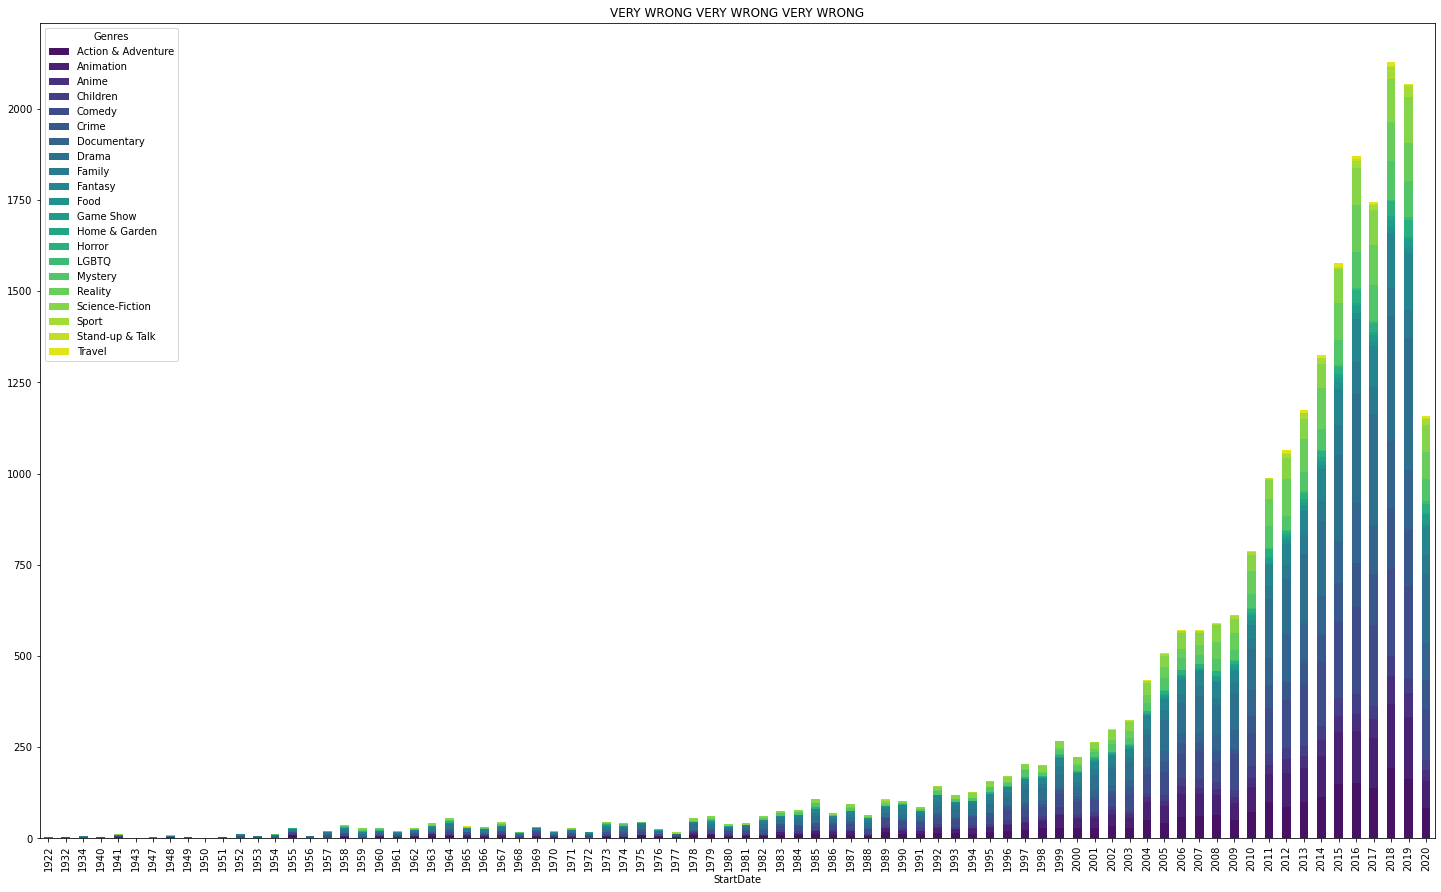

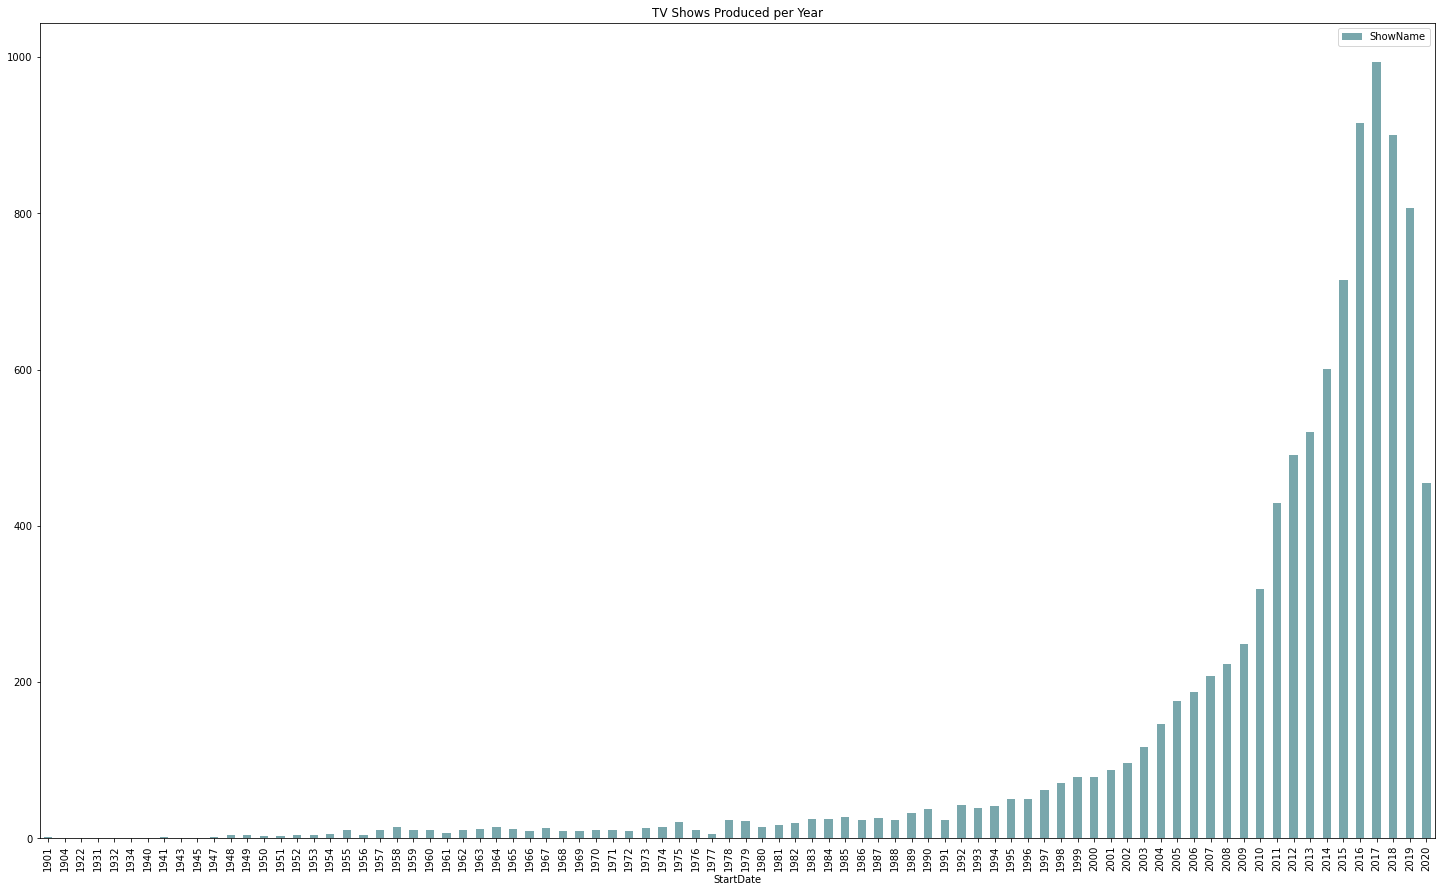

In [38]:
# di ko ulit gets?

# bar chart per year > stacked columns by Genre - this could work if we only have one genre per show
# note that this is wrong since we have multiple genres for the same ShowName
# i'll keep this for future reference but izz VERY WRONG
genres_pipe.filter(items=['ShowName', 'StartDate', 'EndDate', 'RunYears']+all_gen).\
melt(id_vars=['ShowName','StartDate', 'EndDate', 'RunYears']).set_index('value').filter(like='1', axis=0).\
rename(columns={'variable':'Genres'}).groupby('StartDate')['Genres'].value_counts().unstack(level=1).\
plot(kind='bar',title='VERY WRONG VERY WRONG VERY WRONG',stacked=True,colormap=ListedColormap(sns.color_palette("viridis", 21)), figsize=(25,15))


# normal bar chart per StartDate
genres_pipe.filter(items=['ShowName', 'StartDate']).groupby('StartDate').count().plot(kind='bar',title='TV Shows Produced per Year' ,color='#79a7ac', figsize=(25,15))

# line chart for 'On-Air' shows per year - live shows


#### 4. How many shows are there per streaming service (based from Reelgood.com)?

In [29]:
# count here > show count on main df(proj)
# please note that some titles are available on multiple services
service_pipe.filter(items=services).sum().reset_index().rename(columns={'index' : 'Service',0:'Count'})

,Service,Count
0,Netflix,2146
1,Hulu,2067
2,Prime Video,2535
3,Disney+,267
4,HBO,569
5,HBO MAX,519
6,Peacock,46
7,Apple TV+,38
8,fuboTV,1328
9,Showtime,96


#### 5. For each streaming service, what is the targeted age group?

In [30]:
# Run this for codes
# Maturity Rating
for element in services:
    print(f"{element}\nservice_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='{element}',sort_by_col='MaturityRating',filter_cols=['ShowName','MaturityRating']).groupby('MaturityRating').count().rename(columns={{'ShowName':'Count'}}).style.set_caption('{element}')\n")

Netflix
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Netflix',sort_by_col='MaturityRating',filter_cols=['ShowName','MaturityRating']).groupby('MaturityRating').count().rename(columns={'ShowName':'Count'}).style.set_caption('Netflix')

Hulu
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Hulu',sort_by_col='MaturityRating',filter_cols=['ShowName','MaturityRating']).groupby('MaturityRating').count().rename(columns={'ShowName':'Count'}).style.set_caption('Hulu')

Prime Video
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Prime Video',sort_by_col='MaturityRating',filter_cols=['ShowName','MaturityRating']).groupby('MaturityRating').count().rename(columns={'ShowName':'Count'}).style.set_caption('Prime Video')

Disney+
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Disney+',sort_by_col='MaturityRating',filter_cols=['ShowName','MaturityRating']).groupby('MaturityRating').count().rename(columns={'ShowName':'Count'}).style.set_caption('Disn

In [31]:
# wait ang labo hahahha
# basically, count of maturity rating per service?

# Netflix
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Netflix',sort_by_col='MaturityRating',
                  filter_cols=['ShowName','MaturityRating']).groupby('MaturityRating').count().rename(columns={'ShowName':'Count'}).style.set_caption("Netflix")

,Count
MaturityRating,
Rated: All (TV-G),189
Rated: 7+ (TV-PG),357
Rated: 13,0
Rated: 14+ (TV-14),496
Rated: 18+ (TV-MA),442


In [32]:
# Hulu
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Hulu',sort_by_col='MaturityRating',
                  filter_cols=['ShowName','MaturityRating']).groupby('MaturityRating').count().rename(columns={'ShowName':'Count'}).style.set_caption("Hulu")

,Count
MaturityRating,
Rated: All (TV-G),168
Rated: 7+ (TV-PG),427
Rated: 13,0
Rated: 14+ (TV-14),637
Rated: 18+ (TV-MA),275


In [33]:
# Prime Video
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Prime Video',sort_by_col='MaturityRating',
                  filter_cols=['ShowName','MaturityRating']).groupby('MaturityRating').count().rename(columns={'ShowName':'Count'}).style.set_caption('Prime Video')

,Count
MaturityRating,
Rated: All (TV-G),222
Rated: 7+ (TV-PG),280
Rated: 13,0
Rated: 14+ (TV-14),277
Rated: 18+ (TV-MA),168


In [34]:
# Disney+
service_pipe.pipe(get_encoded_sort_desc,col_one_hot_encoded='Disney+',sort_by_col='MaturityRating',
                  filter_cols=['ShowName','MaturityRating']).groupby('MaturityRating').count().rename(columns={'ShowName':'Count'}).style.set_caption('Disney+')

,Count
MaturityRating,
Rated: All (TV-G),96
Rated: 7+ (TV-PG),83
Rated: 13,0
Rated: 14+ (TV-14),24
Rated: 18+ (TV-MA),5


#### 6. What is the average rating of all shows available per streaming services?

In [35]:
#omaygahd and haba... sorry pag madaming variables names naliito na ako :(
pd.pivot_table(service_pipe.filter(items=['Imdb','Reelgood']+services).dropna().melt(id_vars=['Imdb','Reelgood']).\
               rename(columns={'variable':'Services'}).set_index('value').filter(like='1', axis=0),
               index=['Services'],aggfunc=np.mean).round(2)

,Imdb,Reelgood
Services,,
AMC Premiere,7.44,63.13
AcornTV,7.39,54.39
Apple TV+,6.89,62.92
BET+,6.29,44.09
BritBox,7.44,55.33
CBS All Access,6.93,60.25
Cinemax,7.53,68.33
Crunchyroll,6.91,52.89
DC Universe,7.38,61.77


#### 7. Based on the list, which region has the most number of produced shows?

In [36]:
country_pipe.filter(items=['ShowName']+countries_list).melt(id_vars=['ShowName']).\
rename(columns={'variable':'Countries', 'ShowName':'Count'}).set_index('value').\
filter(like='1', axis=0).groupby('Countries').count().sort_values(by='Count',ascending=False)

,Count
Countries,
America,1917
Japan,629
United Kingdom,546
Canada,181
South Korea,67
Australia,60
France,40
Germany,29
Spain,19


#### 9. Which online streaming service is worth the money in terms of quality of shows? 
 how would we quantify this?
 - Ave rating for IMDB and Reelgood
 - Quantity of Aavailable shows (refer to #4)
 - longlasting shows? total run dates

### Additional Questions:

#### Running dates:
- inspect how many years the show ran and it's ratings
- ave running time per service
    - RunYears
    - Seasons
- how many shows are still running.
    - ratings
    - genres
- how many shows has ended.
    - ratings
    - genres